# Pairs Trading In Python

## Table of Contents

### Introduction
### Libraries and Packages
## Part 1: Choosing and Testing A Pair 
 - 
### Choosing A Sector (Financial Services)
 - 
### Cointegration
 - 
### Choosing A Pair 
 - 
### Risk (and Return) Factor Neutrality  


## **Part 2:** Creating A Strategy
 - 
### Moving Averages
 - 
### Moving Average Z-Scores
 - 
### Creating Buy and Sell Signals
 -
### Breaking Down Buy and Sell Signals

## Part 3: Testing The Trading Strategy
 - 
### Simulating Our Trading Strategy
 - 
### Cointegration Period Simulation Results
 - 
### Benchmarking Cointegration Period Performance 
 - 
### Out-Of-Sample Simulation Results
 -
### Areas of Improvement And Final Thoughts

## Introduction

Pairs trading is a market neutral mean-reversion trading strategy that involves matching long and short positions in highly correlated securities. In addition to correlation, pairs trading requires a general understanding of [stationarity](https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc442.htm), [cointegration.](https://www.statisticshowto.com/cointegration/) and the risk factors affecting each stock within a pair.

In part 1, we will go through the process of choosing a target sector, locating a cointegrated pair, and then testing the price ratio and spread of the pair for stationarity. 

In part 2, we will implement a relative value trading strategy that uses rolling averages to take advtange of deviations from "*true*" mean of their price ratio



## Libraries and Packages

In [2]:
import numpy as np
import pandas as pd

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS

import yfinance as yf

import matplotlib.pyplot as plt

# Part 1: Choosing and Testing A Pair 

## Choosing A Sector (Financial Services)
***
One of our main goals when picking our pair is to eliminate as much asymmetrical risk as possible. Because the strategy is long / short neutral at any time, it doesn't matter whether the factor exposure causes the prices to go up or down. What does matter, is that the risk factors affect the pair in a nearly identical fashion. A large difference in driving factors could easily 'break' the cointegration of the pair or destroy the stationarity of the spread / price ratio; this is where the majority of risk in a pairs trading strategy comes from. 

To illustrate this point, let's take the fictional example of a pair of pharmaceutical stocks which have identical stables of drugs. Let's say that they are in fact cointegrated and that their price ratio is stationary (we will explain this later, but for now, just know that they pass the statistical tests for being a 'pair'). Since these stocks are functionally identical, we can capitalize on deviations from their expected mean and make profits when the pair returns to their 'true' price ratio (after all they are identical, so they should move together, be it up or down). Well, if one of the companies suddenly develops a miracle cancer cure, then the returns of the two are no longer being driven by identical factors. Thus, the previous price ratio now indicates nothing and our algorithm would simply keep shorting the stock (and losing money) expecting that *Miracle Drug Co.* should eventually return to its expected price (based on its original relationship with the other stock). This extreme example should drive home the point: **the main risks in pairs trading are not from traditional risk exposure (i.e factors that will make the stock price go down), but from asymmetric risk exposure (i.e factors that will cause the stocks to diverge in the long term)** We will discuss this idea more in the 'Risk (and Return) Factor Neutrality' section

Based on this analysis, I decided on the financial services industry*, as its constituents hold extremely similar structures, risk factors, and revenue streams--perhaps more so than any other sector.  

*Other apt choices could be: Commodities (Namely Energy, Metals, and some Utilities), Real Estate, and Airlines.

*Some sectors that I would steer clear of would be: Biotech / Pharmaceutical (differing drug lineups / R&D prospects), Aerospace & Defense (very contract dependent), Consumer Discretionary (very hard to quantify exposure differences due to branding)

***

First, lets grab a bunch of financial tickers and pull price data.
***

In [3]:
Tickers = ['JPM', 'BAC', 'WFC', 'C', 'BLK', 'GS', 'MS', 'SCHW', 'AXP', 'USB', 'TFC', 'PNC', 'BK', 'COF', 'STT', 'FITB']

data = yf.download(Tickers, start="2013-01-01", end="2018-01-01")
df = data["Adj Close"].dropna(how="all")

df.tail()

[*********************100%***********************]  16 of 16 completed


,AXP,BAC,BK,BLK,C,COF,FITB,GS,JPM,MS,PNC,SCHW,STT,TFC,USB,WFC
Date,,,,,,,,,,,,,,,,
2017-12-22,93.623421,27.800545,49.638512,469.876221,68.443298,95.404030,27.162580,243.448608,97.019302,48.409340,130.877167,49.719582,88.843521,44.947334,48.584419,55.097980
2017-12-26,93.462212,27.707504,49.463863,471.344208,67.799568,94.853447,27.021654,242.273499,96.631035,48.179775,129.784454,49.519096,88.398994,44.582050,48.182972,54.722012
2017-12-27,93.993210,27.660984,49.491440,471.894745,67.899315,94.692070,27.004042,240.609604,96.811623,48.271610,129.856064,49.499992,88.643929,44.528591,48.236488,54.560883
2017-12-28,94.533676,27.726112,49.748825,475.252777,68.071587,95.214180,27.127993,241.126678,97.326309,48.345070,130.474136,49.681389,89.115685,44.653328,48.397976,54.874187
2017-12-29,94.163895,27.465597,49.509827,471.335144,67.464111,94.530678,26.862379,239.490952,96.558807,48.179775,129.238052,49.041752,88.933456,44.296955,48.066048,54.310234


## Cointegration
***
*What is cointegration?*

**From Paul Wilmott's Frequently Asked Questions in Quantitative Finance:**

**Short Answer:**
<blockquote>
Two time series are cointegrated if a linear combination
has constant mean and standard deviation. In other
words, the two series never stray too far from one
another. Cointegration is a useful technique for studying
relationships in multivariate time series, and provides
a sound methodology for modelling both long-run and
short-run dynamics in a financial system.
</blockquote>

**Example:**
<blockquote>
Suppose you have two stocks S1 and S2 and you find
that S1 − 3 S2 is stationary, so that this combination
never strays too far from its mean. If one day this
‘spread’ is particularly large then you would have sound
statistical reasons for thinking the spread might shortly
reduce, giving you a possible source of statistical
arbitrage profit. This can be the basis for pairs trading.
</blockquote>
<br>
With that in mind, we will need to define a function which will take our stock price dataframe and output a cointegration matrix, alongside any pairs meeting our significance value of 0.02

For this task, we will be using [statsmodels](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.coint.html) to import the function which will perform an augmented Engle-Granger two-step cointegration test.
***

In [4]:
def cointegration_checker(stock_dataframe):
    cointegrated_pairs = []
    
    k = stock_dataframe.shape[1]
    #getting the number of columns (tickers)
    p_values = np.ones( (k, k) )
    
    
    keys = stock_dataframe.keys()
    #getting the column names (tickers) from df
    
    for i in range(k):
        for j in range(i+1, k):
            
            Asset_1 = stock_dataframe[keys[i]]
            Asset_2 = stock_dataframe[keys[j]]
            
            #iterating through the df and testing cointegration for all pairs of tickers
            Coint_Test = coint(Asset_1, Asset_2)
            
            pvalue = Coint_Test[1]
            # statsmodels coint returns p-values (our primary concern) in the 1th index slot
            p_values[i, j] = pvalue
            #p value matrix where the output of the coint test is the ith, jth index
            if pvalue < 0.02:
                cointegrated_pairs.append((keys[i], keys[j]))
                
    return p_values, cointegrated_pairs

## Choosing A Pair
***
Using the cointegration checker we created above, we will construct a matrix of possible pairs for easier visualization
***

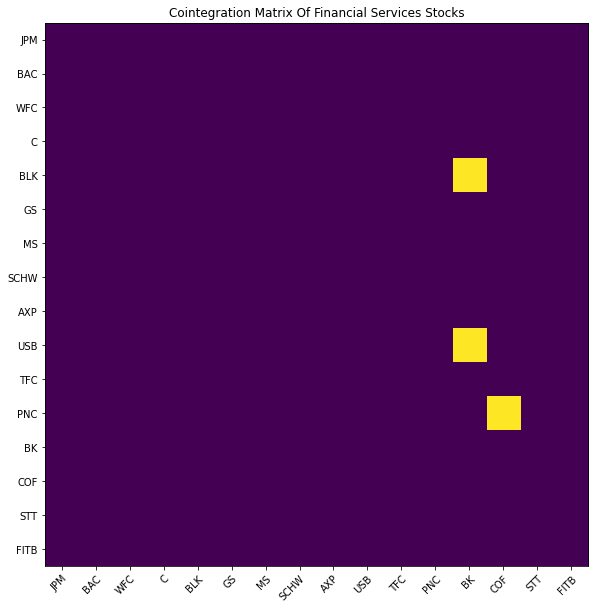

[('C', 'STT'), ('MS', 'STT'), ('SCHW', 'TFC')]


In [5]:
pvalues, pairs = cointegration_checker(df)
fig, ax = plt.subplots(figsize=(25, 10))
im = ax.imshow(pvalues <= .02)

ax.set_xticks(np.arange(len(Tickers)))
ax.set_yticks(np.arange(len(Tickers)))

ax.set_xticklabels(Tickers)
ax.set_yticklabels(Tickers)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_title("Cointegration Matrix Of Financial Services Stocks")
plt.show()
print(pairs)

***
After analyzing the pairs, it appears that the best match is **Citgroup** and **State Street Corp.**<br>

Lets plot the prices and run a standalone cointegration test to make sure everything looks normal. 
***

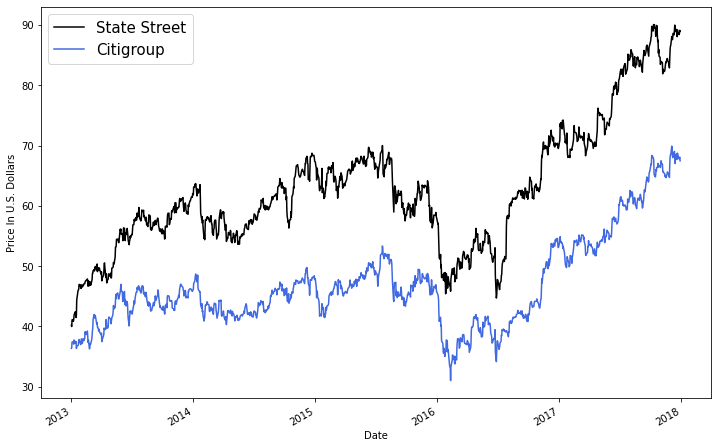

In [6]:
plt.figure(figsize=(12,8))
df['STT'].plot(color = 'black')
df['C'].plot(color = 'royalblue')
plt.legend(['State Street', 'Citigroup'], prop={'size': 15})
plt.ylabel('Price In U.S. Dollars')
plt.show()

In [19]:
placeholder, pvalue, placeholder2 = coint(df['STT'][0:252], df['C'][0:252])
print("The pvalue of the augmented Engle-Granger two-step cointegration test between $C and $STT is", round(pvalue,5))


The pvalue of the augmented Engle-Granger two-step cointegration test between $C and $STT is 0.17249


***
After checking the pvalue and price chart above, it is reasonable to say that STT and C are both cointegrated and correlated.<br>

Next, lets plot the *price ratio* and *price spread* and then test their **stationarity**.

When calculating the **spread**, we will use linear regression to get a coefficient for linear combination between our securities.
***

In [763]:
Asset_1 = df['STT']
Asset_2 =  df['C']

#calculating the spread
Asset_1  = add_constant(Asset_1)
results = OLS(Asset_2, Asset_1).fit()

coef = results.params['STT']
Asset_1 = Asset_1['STT']

spread = Asset_2 - (coef * Asset_1)

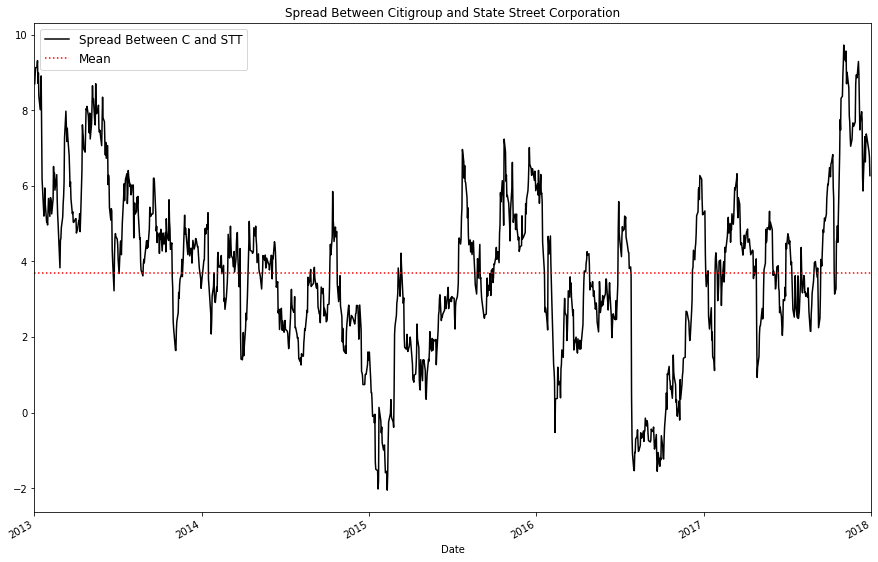

In [771]:
spread.plot(figsize=(15,10), color = 'black')
plt.xlim('2013-01-01', '2018-01-01')
plt.axhline(spread.mean(), color='red', linestyle=':')
plt.legend(['Spread Between C and STT', 'Mean'], prop={'size': 12});
plt.title("Spread Between Citigroup and State Street Corporation")
plt.show()


***
Next, lets calculate the **price ratio**. The price ratio, in this case, is simply computed as higher / lower (State Street / Citigroup)
***

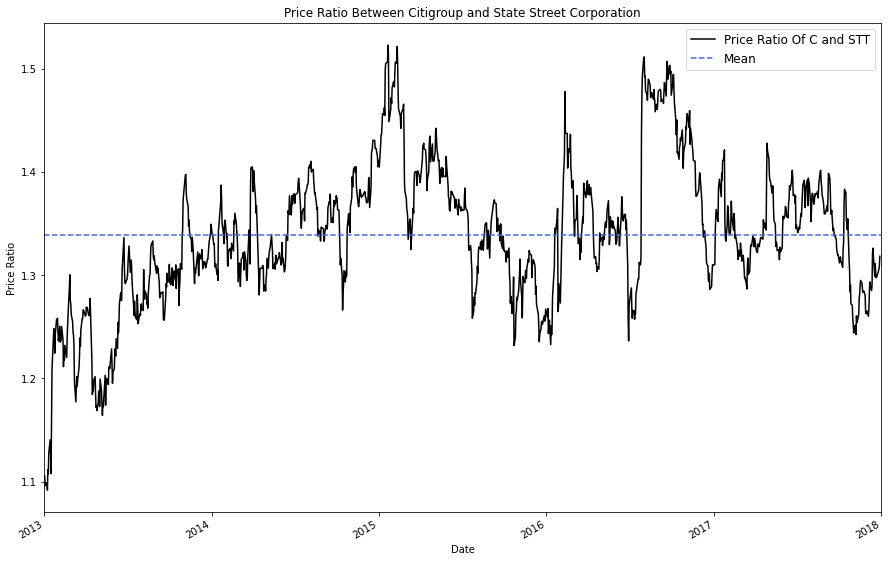

In [779]:
price_ratio = Asset_1/Asset_2
price_ratio.plot(figsize=(15,10), color = 'black')
plt.axhline(price_ratio.mean(), color='royalblue', linestyle='dashed')
plt.xlim('2013-01-01', '2018-01-01')
plt.legend(['Price Ratio Of C and STT', 'Mean'], prop={'size': 12});
plt.title("Price Ratio Between Citigroup and State Street Corporation")
plt.ylabel('Price Ratio')
plt.show()

 ***
 To check if the price ratio is stationary, we will use an *Augmented Dickey–Fuller Test* implemented with [statsmodels](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html)

**Background:** The [*Augmented Dickey Fuller Test*](https://www.statisticshowto.com/adf-augmented-dickey-fuller-test) tests the null hypothesis that a *unit root* is present in a time series sample. In this case, the alternative hypothesis is that no unit root exists (indiciating that the Time Series is stationary). 

[**Unit Root:**](https://www.statisticshowto.com/unit-root/)
A unit root (also called a unit root process or a difference stationary process) is a stochastic trend in a time series, sometimes called a “random walk with drift”; If a time series has a unit root, it shows a systematic pattern that is unpredictable. <br>

Now, lets compute and compare the p-values of both the price spread and price ratio.
***

In [780]:
price_ratio_pvalue = round(adfuller(price_ratio)[1],5)
spread_pvalue = round(adfuller(spread)[1],5)

(price_ratio_pvalue, spread_pvalue)

(7e-05, 0.00035)

***
Based on both the graph of the price ratio and the results of our Augmented Dickey Fuller test, we can say with reasonable certainty that the price ratio of Citigroup and State Street is stationary and will likely fluctuate around a mean of 1.35

The *price ratio* p-value is the lower of the two, so we will be using the price ratio as the stationary mean which we will base our mean-reversion trading strategy on.  

While analyzing the absolute price ratio of the two stocks is important, we should also considering examining a normalized version of the price ratio. To do this, we will be converting the dataframe of *price ratios* into a dataframe of **price ratio Z-scores**. 

This will simplify our decision making by allowing us to quantify the relative 'unusualness' of the price ratio at present time. For instance, a price ratio Z-score of +0.5 might not be that intresting, but a Z-score of +2.5 would be a strong indicator that our higher stock (STT) is likely overvalued. 
***

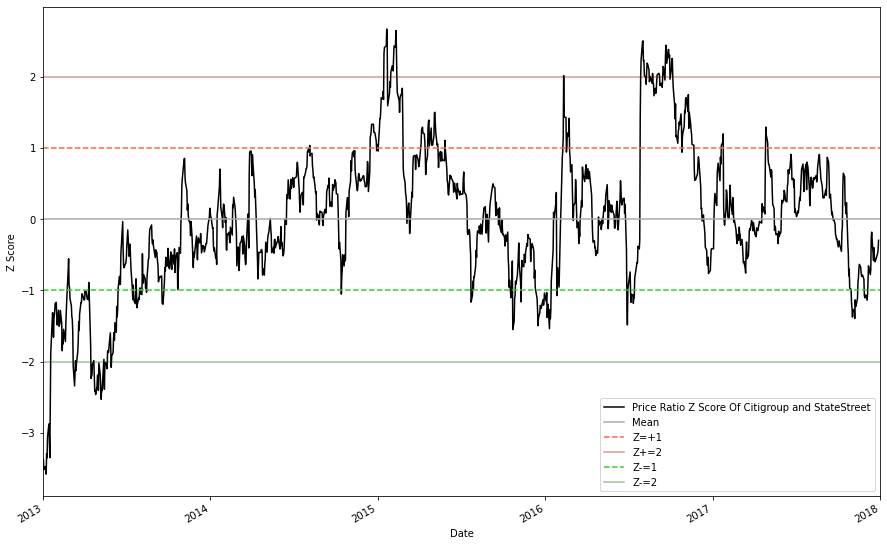

In [781]:
price_ratio_z_score = (price_ratio - price_ratio.mean()) / np.std(price_ratio)
# Z score formula:  (observed value -- mean of the sample) / standard deviation of the sample

price_ratio_z_score.plot(figsize=(15,10), color = 'black')
plt.axhline(price_ratio_z_score.mean(), color = 'darkgrey' )
plt.axhline(1, color='tomato', linestyle='dashed')
plt.axhline(2, color='darkred', alpha = .4)
plt.axhline(-1, color='limegreen', linestyle='dashed')
plt.axhline(-2, color='darkgreen', alpha = .4)


plt.xlim('2013-01-01', '2018-01-01')
plt.legend(['Price Ratio Z Score Of Citigroup and StateStreet', 'Mean', 'Z=+1', 'Z+=2', 'Z-=1', 'Z-=2' ]);
plt.ylabel('Z Score')

plt.show()

***
From the graph we can see that nearly all large divergences will converge back to the approximate mean; this is what we were hoping to see.
***

## Risk (and Return) Factor Neutrality  

***
On top of examining the cointegration and stationarity of the pair, we should take a deep dive into the factors that drive each stocks' returns. We will be using beta to examine the relationship of our pair with various sectors / factors. Traditionally, beta is used in the context of a stock's risk-relationship to the general *market* and is defined as:

$ Beta = \frac{Covariance(Asset1, Benchmark)}{Variance(Benchmark)} \\  $ 

In this project, we will be computing the beta of both our stocks with various benchmarks, then comparing the results to assess factor neutrality. **Ideally, what we would like to see is that both stocks have identical betas in all exposure factors.** On the other hand, a **high factor beta ratio^ would indicate the pair is more suscptiable to that factor,** which would threaten the stationarity of the price ratio. For example, if one stock in the pair was excessively correlated to a factor / sector (say the U.S. Technology Sector), and U.S. Tech was performing extremely succesfully for an extended period of time, the stocks (and their price ratio) would likely diverge; this is the same concept that we discussed in our 'choosing a sector' section. 

In the next code block, I pulled price data for some etfs which will serve as benchmarks for their respective categories. This list is by no means exhaustive, but aims to target major factors / sectors.

**^Note that we are taking the ratio rather than the absolute difference to account for low beta values. 0.2 - 0.1 is a small absolute difference but a large percentage difference.**

***

In [749]:
Factor_Tickers = ['MTUM', 'QUAL', 'IQLT', 'VTV', 'QQQ', 'SIZE', 'SPY', 'XLK', 'IXN','VNQ','ITB', 'XLF', 'STT', 'C']
Factor_Dictionary = {'SPY': 'Market', 'MTUM': 'Momentum', 'IQLT': 'International Quality', 'QQQ': 'Large Cap',
                     'QUAL': 'Quality', 'SIZE': 'Size (Small / Medium)', 'VTV': 'Value', 'XLK': 'US Technology',
                    'IXN':'Global Technology', 'VNQ': 'US Real Estate', 'ITB': 'US HomeBuilding', 'XLF': 'Financial Services'}
factor_data = yf.download(Factor_Tickers, start="2016-01-01", end="2018-01-01")
factor_df = factor_data["Adj Close"].dropna(how="all")

factor_df.head()

[*********************100%***********************]  14 of 14 completed


,C,IQLT,ITB,IXN,MTUM,QQQ,QUAL,SIZE,SPY,STT,VNQ,VTV,XLF,XLK
Date,,,,,,,,,,,,,,
2016-01-04,45.273872,21.832926,25.608055,91.230064,67.328712,104.816719,58.056442,57.771698,181.917801,56.995235,63.383949,70.094666,17.105494,39.188770
2016-01-05,45.034794,22.524345,25.676241,90.963463,67.647499,104.634834,58.211578,57.771698,182.225494,57.082722,64.607063,70.320999,17.171368,39.086788
2016-01-06,44.379551,21.478350,25.082066,89.544685,67.291229,103.629753,57.518047,57.460899,179.926880,55.184052,64.430031,69.319992,16.907867,38.604694
2016-01-07,42.112766,21.123779,24.039818,87.021355,65.791069,100.384743,56.149208,56.473656,175.610184,52.690403,63.174740,67.701019,16.432096,37.464352
2016-01-08,40.846539,20.884438,23.504084,86.297684,65.162895,99.561531,55.510433,55.797226,173.682556,51.316708,62.329830,66.900253,16.175928,37.167686


***
Next, lets define a function for calculating beta. We will be using a simple regression model to compute the beta of our stocks relative to our chosen benchmarks.
***

In [774]:
def beta_calculation(y,x):
    
    x = x.pct_change().iloc[1:]
    x = x.to_frame()
    x = x.values
    
    y = y.pct_change().iloc[1:]
    y = y.to_frame()
    y = y.values
    
    
    x = sm.add_constant(x)
    model = OLS(y,x).fit()
    x = x[:, 1]
    
    return model.params[1]

In [777]:
for i in (Factor_Tickers[:-2]):

    factor_ratio = ((beta_calculation(factor_df['C'],factor_df[i])) / (beta_calculation(factor_df['STT'],factor_df[i])))
    
    print("The exposure of the pair to {} is {}".format(Factor_Dictionary[factor_df[i].name], round(factor_ratio,2)))

The exposure of the pair to Momentum is 1.13
The exposure of the pair to Quality is 1.11
The exposure of the pair to International Quality is 1.07
The exposure of the pair to Value is 1.17
The exposure of the pair to Large Cap is 1.06
The exposure of the pair to Size (Small / Medium) is 1.14
The exposure of the pair to Market is 1.13
The exposure of the pair to US Technology is 1.06
The exposure of the pair to Global Technology is 1.07
The exposure of the pair to US Real Estate is 1.18
The exposure of the pair to US HomeBuilding is 1.16
The exposure of the pair to Financial Services is 1.22


These ratios, while not extremely high, are still larger than we would like. An easy way to mitigate some of this risk in live production would be to test the cointegration every day using sliding windows with varying shorter durations (say 3 months, 6 months, and 1 year). Obviously if this strategy was to be put into production we would build out a much more comprehesive risk mode, but for now I'm content to say that **State Street Corporation (STT) and Citigroup (C) are a suitable pair to formulate a trading strategy with.**

# Part 2: Creating A Strategy

## Moving Averages

Since this trading strategy is at its core, a mean reversion strategy, we can use rolling averages to inform our trading decisions. <BR>

Lets start by plotting the 10 and 60 day moving (rolling) averages against the actual price ratio. 

I arbitrarily chose 10 and 60 day windows for our long and short periods. Hypothetically, we could assess various short / long window lengths and then test the statistical significance of our results for a more robust implementation, but I will leave this for next. 

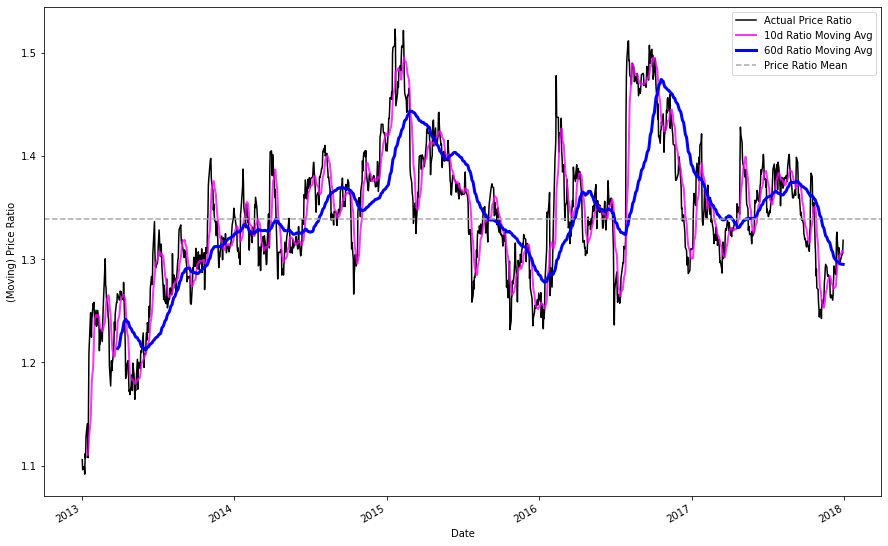

In [789]:
#price ratio = ($STT / $C)
price_ratio = Asset_1/Asset_2

price_ratio_10D_MAVG = price_ratio.rolling(window=10).mean() 
price_ratio_60D_MAVG = price_ratio.rolling(window=60).mean() 

plt.figure(figsize=(15, 10))
price_ratio.plot(color = 'black')
price_ratio_10D_MAVG.plot(color = 'magenta', linewidth=2, alpha = .8)
price_ratio_60D_MAVG.plot(color = 'b', linewidth=3)
plt.axhline(price_ratio.mean(), color = 'darkgrey', linestyle = 'dashed' )
plt.legend(['Actual Price Ratio', '10d Ratio Moving Avg', '60d Ratio Moving Avg', 'Price Ratio Mean'])
plt.ylabel('(Moving) Price Ratio')
plt.show()

## Moving Average Z-Scores

Similarly to our analysis of the composite price ratio, lets examine the rolling Z score of our moving averages to determine if we could use z-scores as trading indicators. 


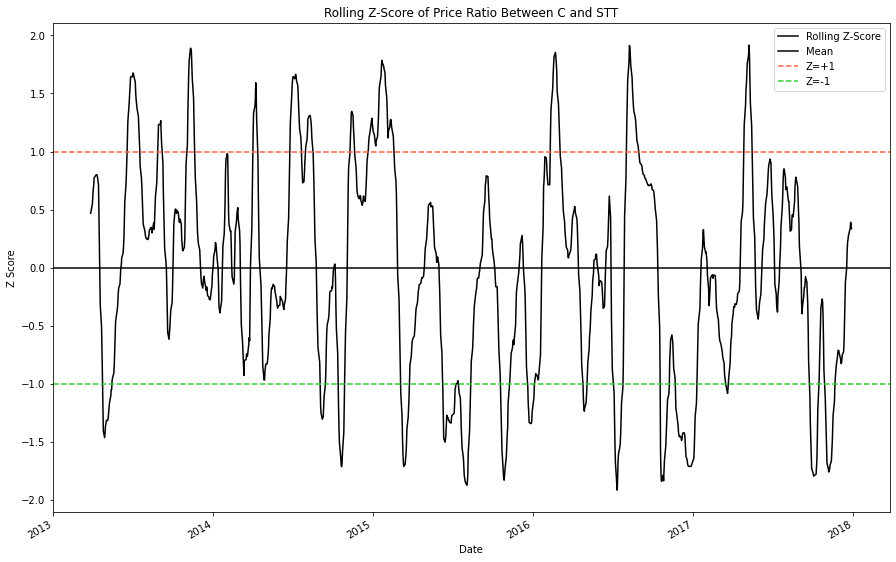

In [790]:
STD_60 = price_ratio.rolling(window=60).std()
Rolling_Z_Score = ((price_ratio_10D_MAVG - price_ratio_60D_MAVG)/STD_60)
Rolling_Z_Score.plot(figsize=(15,10), color = 'black')

#plt.xlim('2013-01-01', '2018-01-01')
plt.axhline(0, color='black')
plt.axhline(1, color='tomato', linestyle='dashed')
plt.axhline(-1, color='limegreen', linestyle='dashed')
plt.legend(['Rolling Z-Score', 'Mean', 'Z=+1', 'Z=-1'])
plt.title("Rolling Z-Score of Price Ratio Between C and STT")
plt.ylabel('Z Score')
plt.show()

The rolling Z-scores appear to consistently drift away from the mean and then revert back to it. 

Accordingly, we should be design a strategy that _'buys'_ the ratio when it is too low and _'sells'_ the ratio when it is too high.

## Creating Buy and Sell Signals

The rules for this strategy are simple: 

 - 
We want to 'buy' the ratio when the rolling z score is lower than 1.25 SD from the mean. 
 - 
We want to 'sell' the ratio when the rolling z score is higher than 1.25 SD from the mean.

Thats it!

To accomplish this, we will make two copies of the price ratio dataframe and then enact the following modifications:

 - 
We want to 'sell' the ratio when the rolling z score is higher than 1.25 SD from the mean, so **we will set all values below +1.25 SD equal to zero, leaving us with the desired sell dates.**
 - 
We want to 'buy' the ratio when the rolling z score is lower than 1.25 SD from the mean, so **we will set all values above -1.25 SD equal to zero, leaving us with the desired buy dates.**

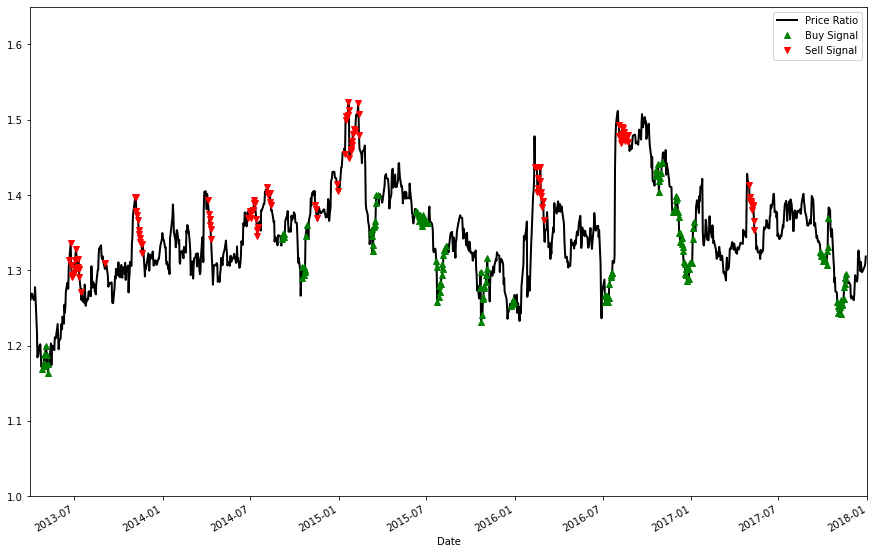

In [931]:
price_ratio.plot(figsize=(15,10), color = 'black', linewidth = 2)
buy  = price_ratio.copy()
sell = price_ratio.copy()


buy[Rolling_Z_Score > -1.25] = 0
buy.plot(color='g', linestyle='None', marker='^')


sell[Rolling_Z_Score < 1.25] = 0
sell.plot(color='r', linestyle='None', marker='v')


plt.axis(('2013-04-01','2018-01-01', 1, 1.65))

plt.legend(['Price Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

## Breaking Down Buy and Sell Signals

_But what exactly does it mean to 'buy' or 'sell' a price ratio?_

Again, the rules are simple:
 - **'Buying' the ratio** means you *buy the higher stock (STT)* and *sell the lower stock (C)*

 - **'Selling' the ratio** means you _sell the higher stock (STT)_ and _buy the lower stock (C)_


To visualize this, we will translate our price ratio buy / sell signals into actions for each stock.  


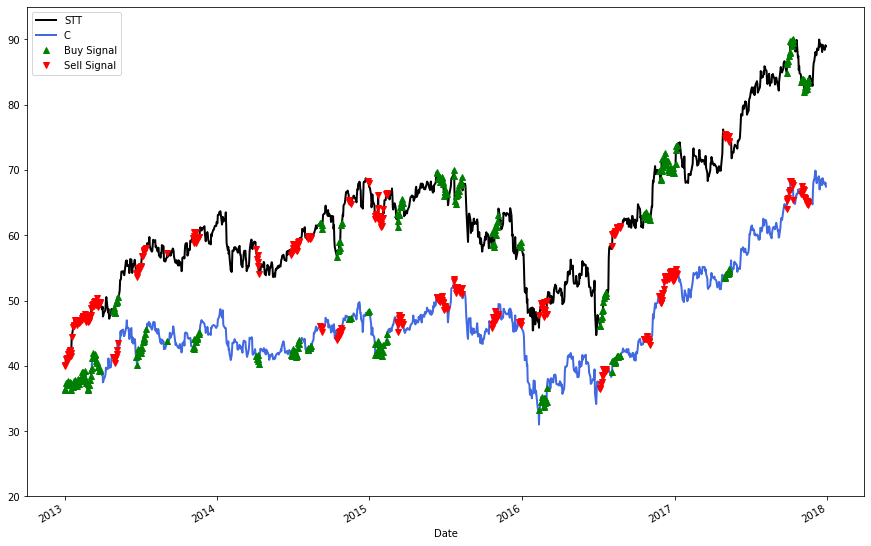

In [812]:
plt.figure(figsize=(15,10))
Asset_1 = df['STT']
Asset_2 = df['C']

Asset_1.plot(color='black', linewidth=2)
Asset_2.plot(color='royalblue', linewidth=2)

Buy_The_Ratio = 0*Asset_1.copy()
Sell_The_Ratio = 0*Asset_1.copy()
#creating blank dfs for our order instructions


# 'buying' the ratio means you buy the higher stock (STT) and sell the lower stock (C)
Buy_The_Ratio[buy!=0] = Asset_1[buy!=0]
Buy_The_Ratio[sell!=0] = Asset_2[sell!=0]

# 'selling' the ratio means you sell the higher stock (STT) and buy the lower stock (C)
Sell_The_Ratio[buy!=0] = Asset_2[buy!=0]
Sell_The_Ratio[sell!=0] = Asset_1[sell!=0]


Buy_The_Ratio.plot(color='g', linestyle='None', marker='^')
Sell_The_Ratio.plot(color='r', linestyle='None', marker='v')

plt.legend(['STT', 'C', 'Buy Signal', 'Sell Signal'])

plt.ylim([20,95])

plt.show()

# Part 3: Testing The Trading Strategy

## Simulating Our Trading Strategy

***
By now, the gist of our trading strategy should be pretty clear.

Lets make a function to simulate our strategy in action.

In order:

 - 
First, we will begin by calculating the price ratio and rolling average z-score of our two assets. 
 - 
Then, we will use _if statements_ to execute trades when the price ratio exceeds +- 1.25 SD; this entails keeping track of the total position sizes (for leverage constraints) and prices that shares of each stock were bought / sold for, so that we can calculate profit later. 
 - 
Afer opening a trade, we will track the position value everyday and close the position if it exceeds our stoploss.
 - 
Finally, we will close our postions when the price ratio z-score is back within normal range (+-0.5 SD).
 - 
Along the way, we will also be keeping track of a multitude of variables to analyze our performance. Among these the number of trades, trade dates, trade gains / losses, and overall profit are all recorded for high / low trades individually.

**Note: _High_ and _Low_ in the following variable declarations refer to trades made when the price ratio is high (+1.25 SD) or low (-1.25 SD)**

Ex. ratio_high_sell = shorting selling Asset_1 when the price ratio z-score was high (+1.25 SD) <br>Ex. profit_low = profit from trades made when the price ratio z-score was low (-1.25 SD)

***

In [57]:
def trading_simulation(Asset1, Asset2, window1, window2, leverage, stop_loss):
    #Asset1 and Asset should be adjusted close price data
    
    #window 2 should exceed window 1 in length
    
    price_ratio = Asset1/Asset2

    moving_average1 = price_ratio.rolling(window=window1).mean()
    moving_average2 = price_ratio.rolling(window=window2).mean()
    std = price_ratio.rolling(window=window2).std()
    
    z_score = ((moving_average1-moving_average2)/std)
    # calculating the z score with moving averages as shown in previous sections
    
    
    profit, profit_high, profit_low = 0,0,0
    ratio_high_sell, ratio_high_buy, ratio_low_buy, ratio_low_sell = 0, 0, 0, 0
    low_trade_total, high_trade_total, = 0,0
    count_high, count_low = 0,0
    old_profit_high, old_profit_low = 0,0
    high_hit_rate, low_hit_rate = [], []
    low_dic, high_dic = {}, {}
    Asset1_shares, Asset2_shares = 0,0
    open_trade = 0
    potential_loss_high, potential_loss_low  = 0,0
    
    df = pd.DataFrame(columns = ['Date', 'Profit'])
    
    for i in range(len(price_ratio)):
        
        
        if z_score[i] > 1.25 and open_trade == 0: 
        #if the price ratio z score is high we will 'sell' the ratio 
        
            #calculating the maximum number of shares for each stock; positions are weighted equally
            Asset1_shares = (leverage // 2) // Asset1[i]
            Asset2_shares = (leverage // 2) // Asset2[i]
            
            
            #selling the ratio means you sell the higher stock (STT) and buy the lower stock (C)
            ratio_high_sell = Asset1[i] * Asset1_shares
            ratio_high_buy = Asset2[i] * Asset2_shares
            
                
            #tracking the number of trades for profit calculation and overall frequency
            count_high += 1
            high_trade_total +=1
            #checker count high with tracker
            open_trade = 1

##############################################################################################################################            
        elif z_score[i] < -1.25 and open_trade == 0:
        #if the price ratio z score is low we will 'buy' the ratio 
        
            #calculating the maximum number of shares for each stock; positions are weighted equally
            Asset1_shares = (leverage // 2) // Asset1[i]
            Asset2_shares = (leverage // 2) // Asset2[i]
            
            #'Buying' the ratio means you buy the higher stock (STT) and sell the lower stock (C)
            ratio_low_buy = Asset1[i] * Asset1_shares
            ratio_low_sell = Asset2[i] * Asset2_shares
            
            count_low += 1
            low_trade_total +=1
            open_trade = 1

##############################################################################################################################            
        if open_trade == 1 and (abs(z_score[i]) > .5):

            potential_loss_high = ((ratio_high_sell - (Asset1[i] * Asset1_shares * count_high)) + ((Asset2[i]*Asset2_shares*count_high) - ratio_high_buy))
            potential_loss_low = (((Asset1[i]*Asset1_shares*count_low) - ratio_low_buy) + (ratio_low_sell - (Asset2[i]*Asset2_shares*count_low)))
            #tracking the current profit from high / low positions 
            
            if potential_loss_high < -stop_loss or potential_loss_low < -stop_loss:
            # if potential losses exceed stop loss then we will cut the positions
            
                old_profit_high = profit_high
                old_profit_low = profit_low
            
            
                profit_high += ratio_high_sell - (Asset1[i] * Asset1_shares * count_high)
                profit_high += (Asset2[i]*Asset2_shares*count_high) - ratio_high_buy
            
                if (profit_high-old_profit_high) != 0:
                    high_hit_rate.append(profit_high-old_profit_high)
                    high_dic[Asset1.index[i].strftime('%Y-%m-%d')] = (profit_high-old_profit_high)
                
                profit_low += (Asset1[i]*Asset1_shares*count_low) - ratio_low_buy
                profit_low += ratio_low_sell - (Asset2[i]*Asset2_shares*count_low)
                
                if (profit_low-old_profit_low) != 0:
                    low_hit_rate.append(profit_low-old_profit_low)
                    low_dic[Asset1.index[i].strftime('%Y-%m-%d')] = (profit_low-old_profit_low)
            
                ratio_high_sell, ratio_high_buy, ratio_low_buy, ratio_low_sell = 0, 0, 0, 0
                count_high,count_low = 0,0
                open_trade = 0
                        
                
            
        
        elif (abs(z_score[i]) < .5):
        #once the z score has returned to 'normal' we will close our positions
            
            #tracking the previous profit level so that we can calculate changes
            old_profit_high = profit_high
            old_profit_low = profit_low
            
            
            profit_high += ratio_high_sell - (Asset1[i] * Asset1_shares * count_high)
            profit_high += (Asset2[i]*Asset2_shares*count_high) - ratio_high_buy
            # profit is derived from (shorted share price - current price) + (current share price - initial long share price)
            
            if (profit_high-old_profit_high) != 0:
            #tracking profit from high trades for metrics
                high_hit_rate.append(profit_high-old_profit_high)
                high_dic[Asset1.index[i].strftime('%Y-%m-%d')] = (profit_high-old_profit_high)
                
            profit_low += (Asset1[i]*Asset1_shares*count_low) - ratio_low_buy
            profit_low += ratio_low_sell - (Asset2[i]*Asset2_shares*count_low)
                
            if (profit_low-old_profit_low) != 0:
            #tracking profit from low trades for metrics
                low_hit_rate.append(profit_low-old_profit_low)
                low_dic[Asset1.index[i].strftime('%Y-%m-%d')] = (profit_low-old_profit_low)
            
            #clearing all positions
            ratio_high_sell, ratio_high_buy, ratio_low_buy, ratio_low_sell = 0, 0, 0, 0
            count_high,count_low = 0,0
            open_trade = 0
            
            
    profit = profit_low + profit_high
    
    high_biggest_loss = min(high_hit_rate)
    high_biggest_gain = max(high_hit_rate)
    
    low_biggest_loss = min(low_hit_rate)
    low_biggest_gain = max(low_hit_rate)
    
    trades_list = high_hit_rate + low_hit_rate
    
    high_list = high_hit_rate
    low_list = low_hit_rate
    
    high_hit_rate = (len([x for x in high_hit_rate if x > 0]) / len(high_hit_rate)) * 100
    low_hit_rate = (len([x for x in low_hit_rate if x > 0]) / len(low_hit_rate)) * 100
    
    print("The total profit between {} and {} was ${:.2f}".format(Asset1.index[0].strftime('%Y-%m-%d'), Asset1.index[len(Asset1)-1].strftime('%Y-%m-%d'), profit ))
    
    print("{} trades where the price ratio was high were executed; they were profitable {:.2f}% of the time, with a largest single gain of ${:.2f}, and a largest single loss of ${:.2f}"
           .format(high_trade_total, high_hit_rate, high_biggest_gain, high_biggest_loss))
    print("{} trades where the price ratio was low were executed they were profitable {:.2f}% of the time, with a largest single gain of ${:.2f}, and a largest single loss of ${:.2f}"
           .format(low_trade_total, low_hit_rate, low_biggest_gain, low_biggest_loss))
        
    trades_dic = {**high_dic, **low_dic}
    #trades_dic = sorted(trades_dic.keys())
    total = leverage
    tracker = []
    for key, value in sorted(trades_dic.items()):
        total += trades_dic[key]
        tracker.append(total)
        
    trades = pd.DataFrame({'Date': list(trades_dic.keys()), 'Profit':list(trades_dic.values()) })
    growth_tracker = pd.DataFrame({'Date': sorted(list(trades_dic.keys())), 'Cumulative Value': tracker})
    growth_tracker = growth_tracker.set_index('Date')
    return  ("High Trades", high_dic), ("Low Trades", low_dic), growth_tracker, ("Total Profit:", profit)
    

Now that our function is made, lets import our pair and test the results in-sample and out-of-sample. 

**Note:**

 - 
In-sample refers to the period in which we tested for cointegration (2013-2018) and out-of-sample refers to the period (2018-2021) where we dont know if the pair is cointegrated.
 - 
The results for 2013-2018 are subject to **forward looking bias** as we know that the pair was cointegrated during the time. The point of simulating trading during this period is two fold:
     - to make sure our strategy works when we **know** that cointegration exists <br>
     - to illustrate a rough baseline of exactly how profitable pairs trading can be when cointegration holds.

We will also be importing 5-year T-Note yield data to calculate the return for a comparable "riskless" asset over the same time period, and additional random stocks to verify the validity of our strategy. 


**In-Sample Tickers:**

In [96]:
Coint_Tickers = [ 'C', 'STT', '^FVX', 'GOOG', 'AAPL', 'T','FB']
test_data = yf.download(Coint_Tickers, start="2013-01-01", end="2018-01-01")
test_df = test_data["Adj Close"].dropna(how="all")
test_df.tail()




[*********************100%***********************]  7 of 7 completed


,AAPL,C,FB,GOOG,STT,T,^FVX
Date,,,,,,,
2017-12-22,42.040852,68.443298,177.199997,1060.119995,88.843521,31.276472,2.251
2017-12-26,40.974274,67.799568,175.990005,1056.739990,88.398994,31.372862,2.237
2017-12-27,40.981483,67.899315,177.619995,1049.369995,88.643929,31.236317,2.199
2017-12-28,41.096786,68.071587,177.919998,1048.140015,89.115685,31.469244,2.234
2017-12-29,40.652374,67.464111,176.460007,1046.400024,88.933456,31.228283,2.206


Date
2013-01-02    0.763
2013-01-03    0.808
2013-01-04    0.819
2013-01-07    0.813
2013-01-08    0.785
              ...  
2017-12-22    2.251
2017-12-26    2.237
2017-12-27    2.199
2017-12-28    2.234
2017-12-29    2.206
Name: ^FVX, Length: 1259, dtype: float64

**Out-Of-Sample Tickers:**

In [77]:
Test_Tickers = [ 'C', 'STT', '^FVX', 'GOOG', 'AAPL', 'T','FB']
test2_data = yf.download(Test_Tickers, start="2018-01-01", end="2021-04-01")
test2_df = test2_data["Adj Close"].dropna(how="all")
test2_df.tail()


[*********************100%***********************]  7 of 7 completed


,AAPL,C,FB,GOOG,STT,T,^FVX
Date,,,,,,,
2021-03-26,121.209999,73.019997,283.019989,2035.550049,85.372528,29.800423,0.856
2021-03-29,121.389999,71.580002,290.820007,2055.949951,84.815910,30.046221,0.891
2021-03-30,119.900002,72.959999,288.000000,2055.540039,85.790001,30.213362,0.910
2021-03-31,122.150002,72.750000,294.529999,2068.629883,84.010002,29.761097,0.938
2021-04-01,NaN,NaN,NaN,NaN,NaN,NaN,0.907


## Cointegration Period Simulation Results

Lets take a look at how our strategy did when tested over a period where we know that cointegration holds. 

In [92]:
#'in-sample'
trading_simulation(test_df['STT'], test_df['C'], 5, 40, 100000, 5000)

The total profit between 2013-01-02 and 2017-12-29 was $38477.66
17 trades where the price ratio was high were executed; they were profitable 81.25% of the time, with a largest single gain of $3745.52, and a largest single loss of $-1475.22
18 trades where the price ratio was low were executed they were profitable 88.89% of the time, with a largest single gain of $3236.18, and a largest single loss of $-883.84


(('High Trades',
  {'2013-07-17': -1475.2200775146484,
   '2013-09-10': 1995.166820526123,
   '2013-11-19': 815.9623947143555,
   '2014-02-05': 2537.277099609375,
   '2014-04-14': 3745.5196647644043,
   '2014-07-18': -60.61799621582031,
   '2014-08-15': 858.8240661621094,
   '2014-12-08': 1208.4047966003418,
   '2015-02-18': -386.6806640625,
   '2015-09-22': 1368.127784729004,
   '2016-02-01': 2723.5733795166016,
   '2016-03-03': 2457.1830978393555,
   '2016-09-09': 857.4477920532227,
   '2016-10-06': 894.4264259338379,
   '2017-01-30': 2565.181930541992,
   '2017-05-16': 714.2291488647461}),
 ('Low Trades',
  {'2013-03-22': 1931.1374740600586,
   '2013-05-22': 588.3607406616211,
   '2014-03-25': 1200.0155868530273,
   '2014-09-16': 1068.4920768737793,
   '2014-10-28': 1974.4127807617188,
   '2015-03-25': 450.3178176879883,
   '2015-07-10': 29.29065704345703,
   '2015-08-11': 220.76516342163086,
   '2015-11-05': -61.36859893798828,
   '2016-01-19': 2350.3444061279297,
   '2016-05-03': 

Now, lets take a look at some random pairs put into the same simulation.

If our strategy has merit, then we should see that random combinations of stocks have poor performance in both total profit and hit rate. 

In [85]:
null = trading_simulation(test_df['T'], test_df['STT'], 5, 40, 100000, 5000)

The total profit between 2013-01-02 and 2017-12-29 was $-3465.31
20 trades where the price ratio was high were executed; they were profitable 68.42% of the time, with a largest single gain of $5870.19, and a largest single loss of $-5361.00
21 trades where the price ratio was low were executed they were profitable 57.14% of the time, with a largest single gain of $5096.20, and a largest single loss of $-5940.68


In [88]:
null = trading_simulation(test_df['GOOG'], test_df['C'], 5, 40, 100000, 5000)

The total profit between 2013-01-02 and 2017-12-29 was $1861.14
23 trades where the price ratio was high were executed; they were profitable 65.22% of the time, with a largest single gain of $4612.42, and a largest single loss of $-7868.41
19 trades where the price ratio was low were executed they were profitable 68.42% of the time, with a largest single gain of $4472.66, and a largest single loss of $-5593.68


In [82]:
null = trading_simulation(test_df['AAPL'], test_df['FB'], 5, 40, 100000, 5000)

The total profit between 2013-01-02 and 2017-12-29 was $-12377.18
18 trades where the price ratio was high were executed; they were profitable 66.67% of the time, with a largest single gain of $6120.14, and a largest single loss of $-5880.20
26 trades where the price ratio was low were executed they were profitable 57.69% of the time, with a largest single gain of $4899.44, and a largest single loss of $-15665.97


## Benchmarking Cointegration Period Performance 

All things considered the strategy looks pretty good.

Lets plot our cumulative returns against a [Five Year Treasury Note](https://www.marketwatch.com/investing/bond/tmubmusd05y?countrycode=bx) (denoted FVX or TMUBMUSD05Y) and compare the results.

To calculate the holding period return we will create a function which calculates the cumulative value of the T-Note and its coupon payments every 6 months.

****Remeber that as Yield To Maturity increases bond price decreases**

In [121]:
def bond_calculation(YTM, duration, coupon_rate, frequency, investment):
    #this is an implementation of the standard bond pricing formula which splits Bond PV into PV of face + future cash flows
    YTM = YTM.dropna()
    YTM = YTM / 100
    #converting ^FVX into percentage rates and dropping null values; data is initially presented as % * 100 (2.5 = 2.5%)
    
    coupon = ((coupon_rate / 100) / frequency) * investment
    #calculating coupon payments based on frequency and desired investment
    
    
    old_price, total, coupon_payment =  0, 0, 0
    
    face = (((coupon/YTM[126])* (1-(1/(1+YTM[126])**duration)) -investment )*((1+YTM[126])**duration))/-1
    
    
    price_dic = {YTM.index[0].strftime('%Y-%m-%d'): investment}
    
    for i in range(126, len(YTM), 126):
        
        price = ((coupon/YTM[i])*(1-(1/(1+YTM[i])**duration)) + (face / (1+YTM[i])**duration))
        
        price_change = price - old_price
        
        coupon_payment += coupon
        
        total = price + coupon_payment
        
        old_price = price
        
        duration -= (1 / frequency)
        
        price_dic[YTM.index[i].strftime('%Y-%m-%d')] = total
        
    
    value_tracker = pd.DataFrame({'Date': list(price_dic.keys()), 'Cumulative Value':list(price_dic.values()) })
    
    value_tracker = value_tracker.set_index('Date')
    
    return value_tracker

Lets see how the T-Note fared:

In [122]:
bond_calculation(test_df['^FVX'], 5, .75, 2, 100000)

,Cumulative Value
Date,
2013-01-02,100000.000000
2013-07-05,100375.000000
2014-01-07,101013.425198
2014-07-10,102140.152216
2015-01-12,104068.601604
2015-07-14,104140.780633
2016-01-12,105488.553963
2016-07-13,107458.311692
2017-01-13,106917.646151


Let's plot the cumulative value for both ventures and see how they stack up. 

The total profit between 2013-01-02 and 2017-12-29 was $38477.66
17 trades where the price ratio was high were executed; they were profitable 81.25% of the time, with a largest single gain of $3745.52, and a largest single loss of $-1475.22
18 trades where the price ratio was low were executed they were profitable 88.89% of the time, with a largest single gain of $3236.18, and a largest single loss of $-883.84


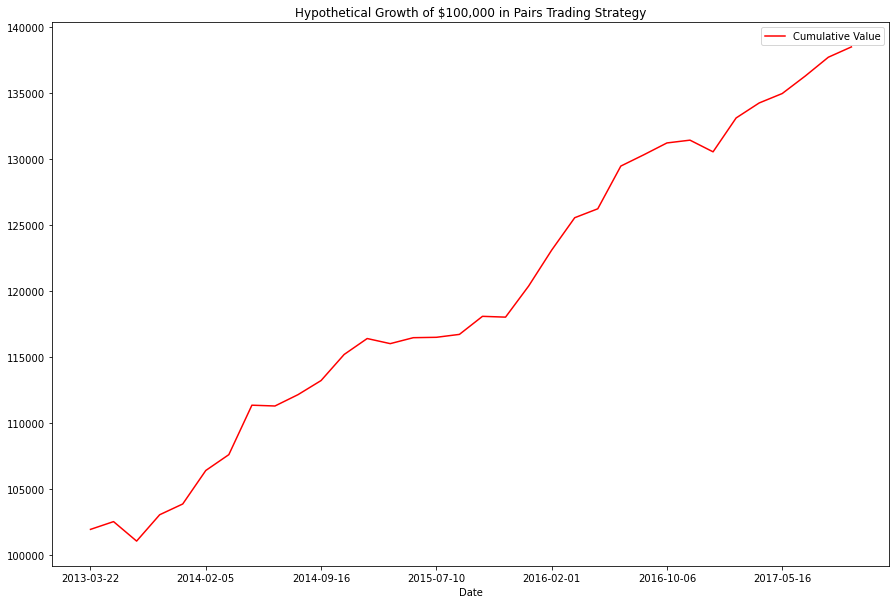

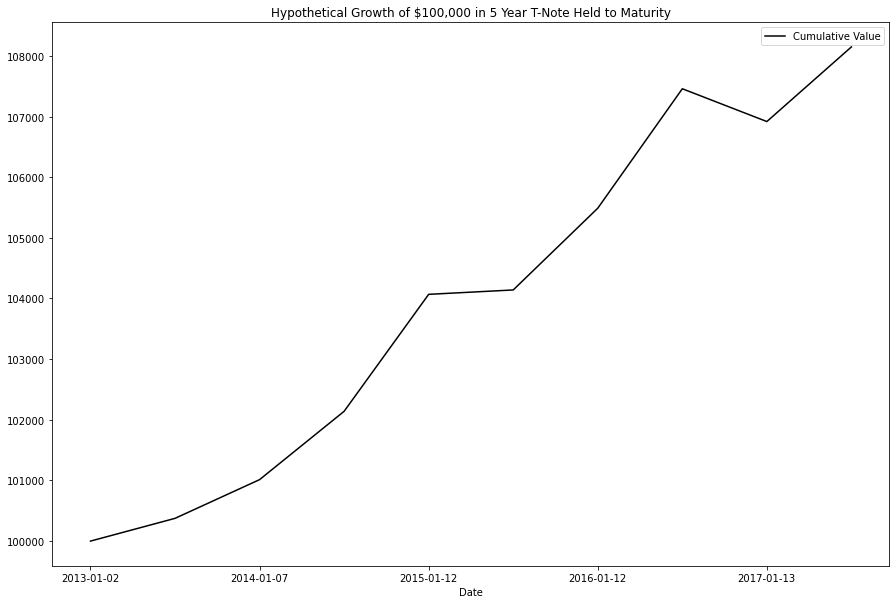

In [141]:
trading_simulation(test_df['STT'], test_df['C'], 5, 40, 100000, 5000)[2].plot(figsize=(15,10),
title= 'Hypothetical Growth of $100,000 in Pairs Trading Strategy', color = 'r')

(bond_calculation(test_df['^FVX'], 5, .75, 2,100000 )).plot(figsize=(15,10),
title= 'Hypothetical Growth of $100,000 in 5 Year T-Note Held to Maturity', color = 'black' );

From the looks of the things, our strategy outearns its 'risk free' by ~30% over 5 years. 

The results look excellent but we need to remember two things:

 - 
Our strategy is not truly as 'risk free' as a treasury note. 
 - 
Forward-Looking Bias — we already knew the pair would be cointegrated over the whole timeperiod 

Nonetheless its usually a good idea to test a strategy in a period where you the desired outcome; if the algorithm doesnt succeed when conditions are known and ideal, it definitely shouldnt see live trials.

At a later date, I may return to this project and see if I better quantify the amount of alpha vs risk that was actually taken on to earn these returns.

## Out-Of-Sample Simulation Results

Now lets see how our strategy fared when tested in period where we do not know its cointegration status. 

In [89]:
#'out-of-sample'
null = trading_simulation(test2_df['STT'], test2_df['C'], 5, 40, 100000,5000)


The total profit between 2018-01-02 and 2021-04-01 was $-20067.23
13 trades where the price ratio was high were executed; they were profitable 76.92% of the time, with a largest single gain of $4212.73, and a largest single loss of $-5909.60
15 trades where the price ratio was low were executed they were profitable 46.67% of the time, with a largest single gain of $3560.34, and a largest single loss of $-6177.59


***
Ouch! I was extremely suprised at the results here, given the promise of the pair, but I think the cause will become clear when examine the price graphs from 2018-2021.

_Side Note: I hope this graph amuses you as much as it amused me when I first saw it._
***

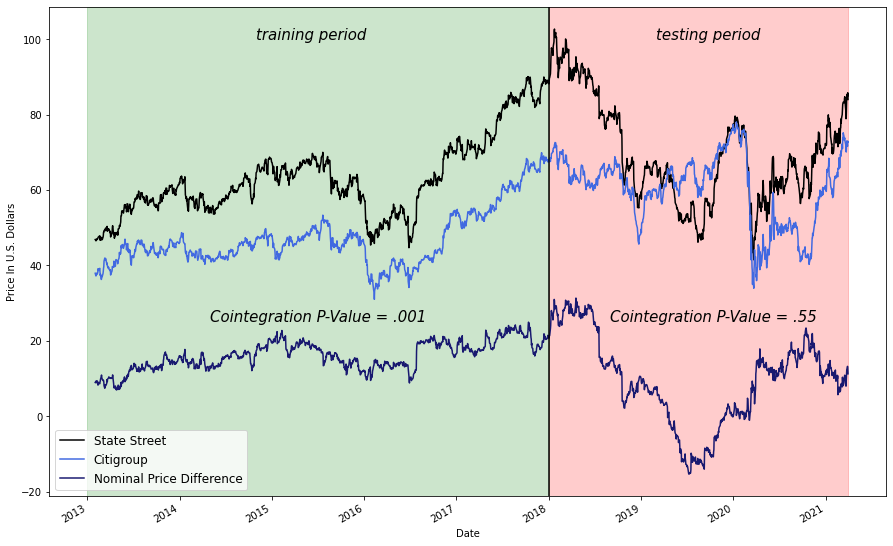

In [148]:
plt.figure(figsize=(15,10))
diff = (test_df['STT'] - test_df['C'])

test_df['STT'].plot(color = 'black')
test_df['C'].plot(color = 'royalblue')
diff.plot(color = 'midnightblue')

plt.legend(['State Street', 'Citigroup', 'Nominal Price Difference'], prop={'size': 12}, loc = 'lower left')

plt.axvline("2018-01-01", color='black')
plt.axvspan('2013-01-01', '2018-01-01', color='green', alpha=0.2)
plt.axvspan('2018-01-01', '2021-04-01', color='red', alpha=0.2)

plt.text("2014-11-01", 100, 'training period', fontsize=15, style='italic')
plt.text("2019-03-01", 100, 'testing period', fontsize=15, style='italic')

plt.text("2018-09-01", 25, 'Cointegration P-Value = .55', fontsize=15, style='italic')
plt.text("2014-05-01", 25, 'Cointegration P-Value = .001', fontsize=15, style='italic')
plt.ylabel('Price In U.S. Dollars')
        
plt.show()

***
This graph explains in part why every brokerage has a generic risk warning that goes something like: <br>
_"All investing is subject to risk, including the possible loss of the money you invest."_

**5 years of near perfect cointegration and correlation and hilariously, it all falls apart right after we stop testing for it.** 

I looked into the factors might have affected State Street's performance during 2018 and found the event that likely broke its cointegration with Citigroup on Wikipedia:
<blockquote>
In 2018, State Street completed its acquisition of Charles River Development, a Burlington, Massachusetts provider of investment management software. The deal closed October 1, 2018, at a cost of approximately $2.6 billion that will be financed by the suspension of share repurchases and the issuing of common and preferred equity. News of the acquisition led to a drop in State Street shares of nearly 10% with share prices remaining flat since the purchase. </blockquote>

While it is disappointing that this strategy did not work in its current iteration, I have plans to test out more sectors, improve trading operations, and ultimately run a similar strategy on a live paper trading platform; more on these in the final section.
***

## Areas of Improvement And Final Thoughts

### Here are some thoughts on improvements and ideas I would like to implement in the future:


### 1. Identical Pairs
Since no pairs are truly identical, I would like to try out this strategy with a large number of pairs from various sectors to mitigate some asynchronous risk.
### 2. Kalman Filters
I would like to test out the efficacy of Kalman filters in place of moving averages.
### 3. Calculating Alpha
Divising a way to better quantify risk so that we can see our strategies true (or at least more truthful) alpha 
### 4. Modular Code
Converting Code (in particular the trading simulation) to be more modular, readable, and concise.
### 5. Live Paper Trading
Ultimately, I would like to implement a relative value trading strategy based on this project into production.

